<div class="alert alert-danger">



# Gibbs Sampling & Parameter Learning


---
In the third notebook, you will familiarise yourself with Gibbs sampling, estimate the (conditional) probability tables (i.e., parameters) of a given network structure from data, and compare the performance of different models in terms of log-likelihood.




In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bayesian_network import BayesNet, Variable
from utils import sample_categorical, sample_lw, get_default_bayes_net

# Gibbs Sampling

<div class="alert alert-warning">
Implement the Gibbs sampling algorithm and use it to approximate $P(A \mid D, E)$.
</div>

In Gibbs sampling, we sample directly from $P( \mathbf{X} \mid \mathbf{E}=\mathbf{e})$. We do this by implicitly constructing a sequence of proposal distributions that converge to the target distribution.

## To Implementation

Implement
- `resampling_distribution`,
- `sample_gibbs`, and
- `gibbs_sampling`.

`resampling_distribution` computes the re-sampling distribution for a given variable.

`sample_gibbs` samples a sequence of random events according to all the relevant re-sampling distributions. 

`gibbs_sampling` approximates $P( X \mid \mathbf{E}=\mathbf{e})$ from a sequence of random events. Again, we will only consider probabilistic queries with one query variable $X$.

### Pre-computing the Re-sampling Distribution


Before we implement the Gibbs sampling algorithm, let us fist write a helper function, which pre-computes the re-sampling distribution $P(X \mid mb(X))$ for an arbitrary variable $X$ in a given Bayesian Network.

Reconsider the Bayesian network from Problem Set 2:

<img width='30%' src='img/bn.svg'>

To pre-compute $P(B \mid mb(B)) = P(B \mid A, C, D)$, we only need the conditional distribution of the $B$ and all of B's children, i.e., $P(B \mid A)$ and $P(D \mid B, C)$


<img width='30%' src='img/mb.png'>


The re-sampling distibution of $B$ can then be computed as follows: $P(B \mid A, C, D) = \frac{ P(D \mid B, C) \cdot P(B \mid A)}{P(D \mid A, C)} = \frac{ P(B, D \mid A, C)}{P(D \mid A, C)} = \frac{ P(B, D \mid A, C)}{\sum_{b \in val(B)} P(B=b, D \mid A, C)}$

As an example, let's compute the re-sampling distribution for $B$ with NumPy. First, let us create the bayes net:

In [2]:
# initialize the Bayes net
_A_, _B_, _C_, _D_, _E_ = 0, 1, 2, 3, 4

A = np.array([0.2, 0.8])
B_A = np.array([[0.9, 0.2], [0.1, 0.8]])
C = np.array([0.9, 0.1])
D_BC = np.array([[[0.1, 0.2], [0.99, 0.8]], [[0.9, 0.8], [0.01, 0.2]]])
E_C = np.array([[0.7, 0.4], [0.3, 0.6]])
            
bayes_net = BayesNet(
    (A, [_A_]),
    (B_A, [_B_, _A_]),
    (C, [_C_]),
    (D_BC, [_D_, _B_, _C_]),
    (E_C, [_E_, _C_])
)

We can use the (conditional) probability distribution tables of each variable (`variable.pdt`) to compute the re-sampling distribution. Note that the axes of `variable.pdt` are in correspondence with the `variable.id`s of all variables, and singleton dimensions are inserted for non-parent variables. This will make computations easier, b/c we don't have to swap dimensions or insert empty dimensions for broadcasting:

In [3]:
print('Shape of P(A):    ', bayes_net[_A_].pdt.shape)
print('Shape of P(B | A):', bayes_net[_B_].pdt.shape)

Shape of P(A):     (2, 1, 1, 1, 1)
Shape of P(B | A): (2, 2, 1, 1, 1)


Computing $P(B \mid A, C, D) = \frac{ P(B, D \mid A, C)}{\sum_{b \in val(B)} P(B=b, D \mid A, C)}$ is easy:

In [4]:
# compute the rdt

# P(D | B, C) * P(B | A) == P(B, D | A, C)
rdt = bayes_net[_D_].pdt * bayes_net[_B_].pdt

# P(D | B, C) * P(B | A) / P(D | A, C) == P(B, D | A, C) / P(D | A, C)
rdt = rdt / rdt.sum(axis=_B_, keepdims=True)


The dimensions of the re-sampling distribution table are sorted by variable id, and singleton dimensions of size 1 are inserted for non-Markov-blanket variables. This is also the expected output format of the *resampling_distribution* function.

## Pre-computing All the Re-sampling Distributions

The `BayesNet` class has an optional constructor argument that we did not use so far: It can take a function that computes the resampling distribution for a given variable. If this is provided, the `BayesNet` will use it to precompute resampling distribution tables for all its variables upon construction. These will come useful when we implement Gibbs sampling.

<div class="alert alert-warning">
    To implement:  <i>resampling_distribution</i> function, which computes the re-sampling distribution for a given variable.
</div>

`resampling_distribution` takes two parameters:
- `variable` is a `Variable` object for which the re-sampling distribution is to be computed.
- `bayes_net` is a `BayesNet` object which holds the (conditional) probability distribution table of each variable.

`resampling_distribution` returns a tuple containing two objects:
- a `np.ndarray` containing the re-sampling distribution $P(X \mid \textit{mb}(X))$ of the variable. The dimensions of the re-sampling distribution table must be sorted by variable id, and singleton dimensions of size 1 must be inserted for non-Markov-blanket variables.
- a `set` containing the IDs of all variables in $\textit{mb}(X)$. 

In [5]:
def resampling_distribution(variable: Variable, bayes_net: BayesNet):
    '''
    Computes the resampling distribution given a variable and a Bayesian network.
    :param variable: The variable for which to compute the resampling distribution.
    :param bayes_net: A Bayesian network of type BayesNet. The bayes net is used to obtain 
                      probability table from child variables.
    :returns: A tuple containing the resampling distribution ('rdt') and a list containing
              the IDs of variables in the Markov blanket ('mb').
    '''
    
    mb =  set()
    
    #children of the variable
    variable_children = set(variable.children)
    mb.update(variable.parents)
    mb.update(variable.children)

    
    rdt = variable.pdt
    for i in variable_children:
        rdt = rdt * bayes_net[i].pdt
        mb.update(bayes_net[i].parents)
    
    mb = mb.difference(set([variable.id]))
    rdt = rdt / rdt.sum(axis = variable.id, keepdims=True)
    
    assert rdt.ndim == len(bayes_net)
    assert variable.id not in mb
    assert type(mb) is set
    
    return rdt, mb

In [6]:
# get_default_bayes_net returns the same Bayes net as defined above; just in case the variable was modified...
bayes_net = get_default_bayes_net()

# compute resampling distribution table of P( B | mb(B) ); same as above 
rdt = bayes_net[_D_].pdt * bayes_net[_B_].pdt
rdt = rdt / rdt.sum(axis=_B_, keepdims=True)
# set containing all the indices of the variables in mb(B)
mb = {_A_, _D_, _C_}

expected = rdt, mb
actual = resampling_distribution(bayes_net[_B_], bayes_net)

#sanity checks
assert type(actual[1]) == type(expected[1]), f'Set of parents has wrong data type.\n Expected: {type(expected[1])}\nGiven: {type(actual[1])}'
assert actual[1] == expected[1], f'The variables in the Markov blanket are not correct.\n Expected: {expected[1]}\nGiven: {actual[1]}'

assert expected[0].shape == actual[0].shape, f'\nResampling distribution has the wrong shape!\nExpected: {expected[0].shape}\nGiven:\t  {actual[0].shape}'
assert expected[0].dtype == actual[0].dtype, f'\nWrong numpy array data type!\nExpected: {expected[0].dtype}\nGiven:\t  {actual[0].dtype}'
assert np.all(np.isclose(expected[0], actual[0])), f'Computation of resampling distribution did not yield the correct result.'


### Gibbs Sampling
<div class="alert alert-warning">
To implement: <i>sample_gibbs</i> function, which samples directly from $P( \mathbf{X} \mid \mathbf{E}=\mathbf{e})$.
</div>

`sample_gibbs` takes five parameters:
- `bayes_net` is a `BayesNet` object to draw samples from (it uses your `resampling_distribution()` from above).
- `sample_size` is the number of samples to use for the estimation.
- `evidence` is a dictionary of variable_ids (keys) and values (values) assigned to the variable. (optional, default = {})
- `burn_in_samples` gives the number of burn-in steps to take (>= 0). (optional, default = 0)
- `sample_distance` gives the number of steps to take to get the next sample (> 0). (optional, default = 1)

`sample_gibbs` function must return one object:
- samples from $P( \mathbf{X} \mid \mathbf{E}=\mathbf{e})$ of type `np.ndarray`, with shape `(sample_size, len(bayes_net))`



In [7]:
def sample_gibbs(bayes_net: BayesNet, sample_size: int, evidence: dict={}, burn_in_samples: int=0, sample_distance: int=1):
    '''
    Returns sample_size samples from the P( X | E=e ).
    :param bayes_net: A Bayesian network of type BayesNet.
    :param sample_size: The number of samples to use for the estimation.
    :param evidence: A dictionary of evidence variables (keys, int) and their correponding values (values, int).
    :param burn_in_samples: The number of burn-in samples to throw away (>= 0).
    :param sample_distance: Use only every n-th sample. (> 0)
    :returns: A NumPy array of type np.int64 with shape (sample_size, len(bayes_net)).
    '''

    
    assert burn_in_samples >= 0
    assert sample_distance > 0
    
    samples = np.empty((sample_size, len(bayes_net)), np.int64)
    samples[0] = sample_lw(bayes_net, 1, evidence=evidence)[0]
    def n_steps(bayes_net, random_event, steps):
        for _ in range(steps):
            for variable in bayes_net:
                if variable.id not in evidence:
                    distribution = variable(random_event, resampling=True)
                    random_event[variable.id] = sample_categorical(distribution)
                else:
                    random_event[variable.id] = evidence[variable.id]
        return random_event
    samples[0] = n_steps(bayes_net, samples[0], burn_in_samples) 
    for i in range(1, sample_size):
        samples[i] = n_steps(bayes_net, samples[i-1].copy(), sample_distance)
    return samples


In [8]:
# get_default_bayes_net returns the same Bayes net as defined above; just in case the variable was modified...
# this time we also pass the function to pre-compute the resampling distributions
bayes_net = get_default_bayes_net(resampling_distribution=resampling_distribution)

np.random.seed(0)
expected = np.array([[0, 0, 0, 1, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1]], dtype=np.int64)
actual = sample_gibbs(bayes_net, 6, {0:0}, 7, 3)

# sanity checks
assert type(actual) == type(expected), f'\nWrong output type!\nExpected: {type(expected)}\nGiven:\t  {type(actual)}'
assert actual.shape == expected.shape, f'\nWrong output shape!\nExpected: {expected.shape}\nGiven:\t  {actual.shape}'
assert actual.dtype == expected.dtype, f'\nWrong numpy array data type!\nExpected: {expected.dtype}\nGiven:\t  {actual.dtype}'
assert np.all(np.isclose(actual, expected)), f'samples and reference samples do not match.\nExpected:\n{expected}\n\nGiven:\n{actual}\n\nIf your last two samples are the same, this may hint at a bug.'

<div class="alert alert-warning">
To implement: <i>gibbs_sampling</i> function to estimate the probability distribution over the query variable $X$ given the evidence $\mathbf{E}=\mathbf{e}$, $P(X \mid \mathbf{E}=\mathbf{e})$.
</div>

`gibbs_sampling` takes six parameters:
- `bayes_net` is a `BayesNet` object to draw samples from.
- `query_variable_id` is the id of the query variable (int).
- `evidence` is a dictionary of variable_ids (keys) and values (values) assigned to the variable. (optional, default = {})
- `sample_size` gives the number of samples to use for the estimation (optional, default = 100).
- `burn_in_samples` gives the number of burn-in samples to throw away (>= 0). (optional, default = 0)
- `sample_distance` gives the number of steps to take to get the next sample (> 0). (optional, default = 1)

`gibbs_sampling` function must return one object:
-  The probability distribution over variable $X$ of type `np.ndarray` with shape `(bayes_net[query_variable_id].num_values,)`.


In [9]:
def gibbs_sampling(bayes_net: BayesNet, query_variable_id: int, evidence: dict={}, sample_size: int=100, burn_in_samples: int=0, sample_distance: int=1):
    '''
    Estimates the distribution of the query variale given the value of the evidence variables.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param query_variable_id: The id of the query variable (int).
    :param evidence: A dictionary of evidence variables (keys, int) and their correponding values (values, int).
    :param sample_size: The number of samples to use for the estimation.
    :burn_in_samples: The number of burn-in samples to throw away (>= 0).
    :param sample_distance: Use only every n-th sample. (> 0)
    :returns: A NumPy array of type np.float64 representing the conditional distribution of the query variable given evidence. 
    '''
    
    # draw samples...
    smpls = sample_gibbs(
        bayes_net, 
        sample_size, 
        evidence=evidence, 
        burn_in_samples=burn_in_samples, 
        sample_distance=sample_distance
    )
    
    query_count = np.bincount(smpls[:,query_variable_id],minlength = bayes_net[query_variable_id].num_values)
    distribution = query_count / len(smpls)

    return distribution

In [10]:
# get_default_bayes_net returns the same Bayes net as defined above; just in case the variable was modified...
# again, we also pass the function to pre-compute the resampling distributions
bayes_net = get_default_bayes_net(resampling_distribution=resampling_distribution)

np.random.seed(0)
expected = np.array([0.25, 0.75], dtype=np.float64)
actual = gibbs_sampling(bayes_net, 0, {2:1}, 100, 5, 3)

# sanity checks
assert type(actual) == type(expected), f'\nWrong output type!\nExpected: {type(expected)}\nGiven:\t  {type(actual)}'
assert actual.shape == expected.shape, f'\nWrong output shape!\nExpected: {expected.shape}\nGiven:\t  {actual.shape}'
assert actual.dtype == expected.dtype , f'\nWrong numpy array data type!\nExpected: {expected.dtype}\nGiven:\t  {actual.dtype}'
assert  np.all(np.isclose(actual, expected)), f'Wrong output value.'




## Example


Reconsider the Bayesian Network from the previous problems:

<img width='30%' src='img/bn.svg'>

The conditional probability tables are given as:

<table style="float: left;margin:5px;"><tr><th>P(A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>-</td><td>0.2</td><td>0.8</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(C)</th><th>$c_0$<br></th><th>$c_1$</th></tr><tr><td>-</td><td>0.9</td><td>0.1</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(B | A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>$b_0$</td><td>0.9</td><td>0.2</td></tr><tr><td>$b_1$</td><td>0.1</td><td>0.8</td></tr></table>


<table style="float: left;margin:5px;"><tr><th rowspan="2">P(D | B, C)</th><th colspan="2">$b_0$<br></th><th colspan="2">$b_1$</th></tr><tr><td>$c_0$</td><td>$c_1$</td><td>$c_0$</td><td>$c_1$</td></tr><tr><td>$d_0$<br></td><td>0.1</td><td>0.2</td><td>0.99</td><td>0.8</td></tr><tr><td>$d_1$</td><td>0.9</td><td>0.8</td><td>0.01</td><td>0.2</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(E | C)</th><th>$c_0$</th><th>$c_1$</th></tr><tr><td>$e_0$</td><td>0.7</td><td>0.4</td></tr><tr><td>$e_1$</td><td>0.3</td><td>0.6</td></tr></table>

In [11]:
bayes_net = get_default_bayes_net(resampling_distribution=resampling_distribution)

### Comparison

Run the following code cell to plot the average [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the exact distribution $P(A \mid D, E)$ and the approximations computed with Gibbs sampling. Different lines represent different value assignments to the evidence variables $D$ and $E$.

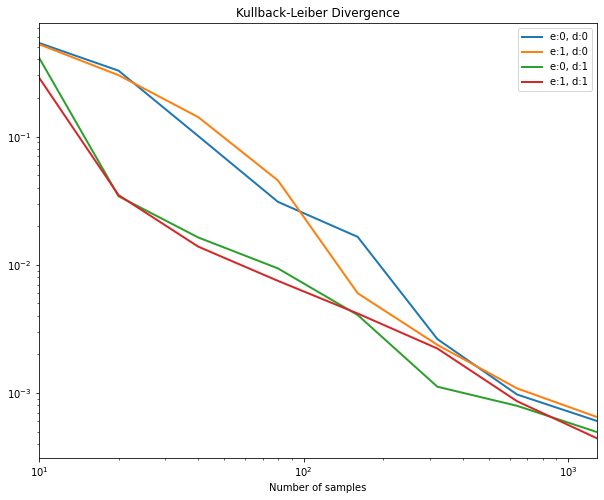

In [12]:
from utils import approx_error

_A_, _B_, _C_, _D_, _E_ = 0, 1, 2, 3, 4

A = np.array([0.2, 0.8])
B_A = np.array([[0.9, 0.2], [0.1, 0.8]])
C = np.array([0.9, 0.1])
D_BC = np.array([[[0.1, 0.2], [0.99, 0.8]], [[0.9, 0.8], [0.01, 0.2]]])
E_C = np.array([[0.7, 0.4], [0.3, 0.6]])

ABCDE = A[:, None, None, None, None] * B_A.T[:, :, None, None, None] * C [None, None, :, None, None] * D_BC.transpose(1, 2, 0)[None, :, :, :, None] * E_C.T[None, None, :, None, :]
ADE = ABCDE.sum(axis=(1, 2))
A_DE = ADE / ADE.sum(axis=0)[None, :, :]

np.random.seed(0)
errs = {}
sample_counts = np.array([10, 20, 40, 80, 160 , 320, 640, 1280])

# compute approximation error
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    errs[(d, e)] = approx_error(
        bayes_net,
        gibbs_sampling,  
        A_DE[:, d, e],
        _A_,
        {_D_:d, _E_:e}, 
        sample_counts,
        n_runs=100,
        burn_in_samples=0,
        sample_distance=1
    )

# plot
plt.figure(figsize=(10, 8))
plt.title('Kullback-Leiber Divergence')
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    plt.plot(sample_counts, errs[(d, e)], label=f'e:{e}, d:{d}', lw=2)
    
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(sample_counts.min(), sample_counts.max())
plt.xlabel('Number of samples')
plt.show()